<a href="https://colab.research.google.com/github/hothiyen/LSTM_DEMO/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/driver')

Drive already mounted at /content/driver; to attempt to forcibly remount, call drive.mount("/content/driver", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow import keras
import warnings
warnings.filterwarnings("ignore")

numpy: Giúp xử lý số liệu
panda: dùng để đọc dữ liệu
pyplot: Dùng để vẽ biểu đồ
MinMaxScaler: Dùng để chuẩn hóa dữ liệu
Và một số thư viện để lập trình cho mô hình mạng dựa trên thư viện keras

Thực hiện lấy data bằng thư viện panda, sau đó tiến hành chia dữ liệu thành 2 bộ, một bộ train chiếm 80% dữ liệu chính, và một bộ test chiếm 20% còn lại của dữ liệu.

In [ ]:
data = pd.read_csv('/content/driver/My Drive/AAPL.csv')


data_end = int(np.floor(0.8*(data.shape[0])))
train = data[0:data_end]['Open']
train =train.values.reshape(-1)
test = data[data_end:]['Open'].values.reshape(-1)
date_test = data[data_end:]['Date'].values.reshape(-1)

In [ ]:
def get_data(train,test,time_step,num_predict,date):
  x_train= list()
  y_train = list()
  x_test = list()
  y_test = list()
  date_test= list()

  for i in range(0,len(train) - time_step - num_predict):
    x_train.append(train[i:i+time_step])
    y_train.append(train[i+time_step:i+time_step+num_predict])

  for i in range(0, len(test) - time_step - num_predict):
    x_test.append(test[i:i+time_step])
    y_test.append(test[i+time_step:i+time_step+num_predict])
    date_test.append(date[i+time_step:i+time_step+num_predict])
  
  return np.asarray(x_train), np.asarray(y_train), np.asarray(x_test), np.asarray(y_test), np.asarray(date_test)

Trước hết để giải thích hàm trên thì mình xin giải thích một số điều như sau:

time_step: Trong bài toán này thì bạn hiểu là nếu bạn muốn cứ 30 giá trị của Open thì đoán 1 giá trị open tiếp theo thì time_step ở đây bằng 30. Còn num_predict là 1. Từ đó ta thấy hàm get_data ở trên mục đích là định dạng lại dữ liệu để tí có thể đưa vào mạng. Ví dụ, sau khi qua hàm get_data thì: x_train = [[1,2,3,4,5,6,7,8,9,10],[2,3,4,5,6,7,8,9,10,11]] và y_train = [11,12] Bản chất là mình muốn dùng [1,2,3,4,5,6,7,8,9,10] để đoán ra 11, [2,3,4,5,6,7,8,9,10,11] để đoán ra 12. 

In [ ]:
x_train, y_train, x_test, y_test, date_test = get_data(train,test,30,1, date_test)

# dua ve 0->1 cho tap train
scaler = MinMaxScaler()
x_train = x_train.reshape(-1,30)

x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)

# dua ve 0->1 cho tap test
x_test = x_test.reshape(-1,30)

x_test = scaler.fit_transform(x_test)
y_test = scaler.fit_transform(y_test)

Ở đây, mình đã code theo kiểu lấy 30 dữ liệu để đoán 1 dữ liệu tiếp theo. Sau đó mình chuẩn hóa dữ liệu về dạng từ 0 đến 1, theo hàm MinMaxScaler() cho bộ train và test. Mục đích của chuẩn hóa là để tí nữa vào mô hình mạng nó tối ưu tốt hơn. Tiếp theo, chúng ta sẽ reshape lại cho x_train và y_train :

In [ ]:
# Reshape lai cho dung model
x_train = x_train.reshape(-1,30,1)
y_train = y_train.reshape(-1,1)

#reshape lai cho test
x_test = x_test.reshape(-1,30,1)
y_test = y_test.reshape(-1,1)
date_test = date_test.reshape(-1,1)

In [ ]:
#dau vao 30 doan 1
n_input = 30
n_features = 1

model = Sequential()
model.add(LSTM(units=50,activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=50))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Bước đầu tiên, chúng ta cần khởi tạo lớp Sequential. Đây sẽ là lớp mô hình của chúng tôi và chúng tôi sẽ thêm các lớp LSTM, Dropout và Dense cho mô hình này. Ở trên ta thêm vào 3 lớp LSTM liên tiếp, và cứ qua 1 lớp là có 1 dropout 0.3 . Cuối cùng ta cho qua một tầng Dense với đầu ra là 1 chiều.

In [ ]:
model.compile(optimizer='adam', loss='mse')

Mình sử dụng hàm loss bình phương trung bình là hàm mất mát và để tối ưu hóa thuật toán, chúng tôi sử dụng trình tối ưu hóa adam.

Thực hiện huấn luyện mạng với validation là 0.2, batch_size =30 và tiến hành lưu lại mô hình



In [ ]:
model.fit(x_train, y_train, epochs=500, validation_split=0.2, verbose=1, batch_size=30)
model.save('/content/driver/My Drive/train')

Epoch 1/500
43/43 [==============================] - 7s 68ms/step - loss: 0.0453 - val_loss: 0.0064
Epoch 2/500
43/43 [==============================] - 2s 47ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 3/500
43/43 [==============================] - 2s 46ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 4/500
43/43 [==============================] - 2s 46ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 5/500
43/43 [==============================] - 2s 46ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 6/500
43/43 [==============================] - 2s 47ms/step - loss: 0.0027 - val_loss: 0.0043
Epoch 7/500
43/43 [==============================] - 2s 46ms/step - loss: 0.0021 - val_loss: 0.0092
Epoch 8/500
43/43 [==============================] - 2s 46ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 9/500
43/43 [==============================] - 2s 46ms/step - loss: 0.0023 - val_loss: 0.0055
Epoch 10/500
43/43 [==============================] - 2s 47ms/step - loss: 0.0019 - val_loss: 0.0077

INFO:tensorflow:Assets written to: /content/driver/My Drive/train/assets


INFO:tensorflow:Assets written to: /content/driver/My Drive/train/assets


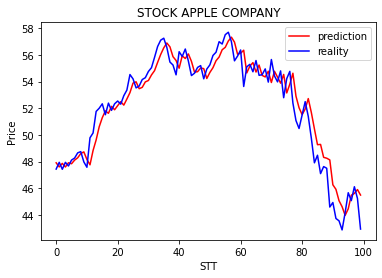

In [ ]:
model = keras.models.load_model('/content/driver/My Drive/train')

test_output = model.predict(x_test)

# print(test_output)
test_1 = scaler.inverse_transform(test_output)
test_2=scaler.inverse_transform(y_test)
plt.plot(test_1[:100], color='r')
plt.plot(test_2[:100] ,color='b')
plt.title("STOCK APPLE COMPANY")
plt.xlabel("STT")
plt.ylabel("Price")
plt.legend(('prediction', 'reality'),loc='upper right')
plt.show()